# baseline

In [175]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [176]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
import geopy.distance

import random
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/test.csv')
bus = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/bus_bts.csv')

In [177]:
# 1. date 변수 변환
train['date'] = pd.to_datetime(train['date']) # datetime 변환
train['weekday'] = train['date'].dt.weekday # 요일 변환
train = pd.get_dummies(train, columns=['weekday']) # 요일 getdummy로 펼치기

test['date'] = pd.to_datetime(test['date']) 
test['weekday'] = test['date'].dt.weekday 
test = pd.get_dummies(test, columns=['weekday'])

In [178]:
# 2. in_out 변수 변환(시내가 훨씬 많음)
train['in_out'] = train['in_out'].map({'시내':0, '시외':1})
test['in_out'] = test['in_out'].map({'시내':0, '시외':1})

In [179]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1


In [180]:
# 3. 승하차 시간대 통합
# 예측하려는 퇴근시간대가 2시간을 예측해야하므로, 2시간 단위로 통합해준다!
## 이런 인사이트를 가지려면 대체 어떻게해야하는거냐,,,,,,

train['68_ride']=train['6~7_ride']+train['7~8_ride'] 
train['810_ride']=train['8~9_ride']+train['9~10_ride']
train['1012_ride']=train['10~11_ride']+train['11~12_ride']

train['68_off']=train['6~7_takeoff']+train['7~8_takeoff'] 
train['810_off']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012_off']=train['10~11_takeoff']+train['11~12_takeoff']

test['68_ride']=test['6~7_ride']+test['7~8_ride'] 
test['810_ride']=test['8~9_ride']+test['9~10_ride']
test['1012_ride']=test['10~11_ride']+test['11~12_ride']

test['68_off']=test['6~7_takeoff']+test['7~8_takeoff'] 
test['810_off']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012_off']=test['10~11_takeoff']+test['11~12_takeoff']

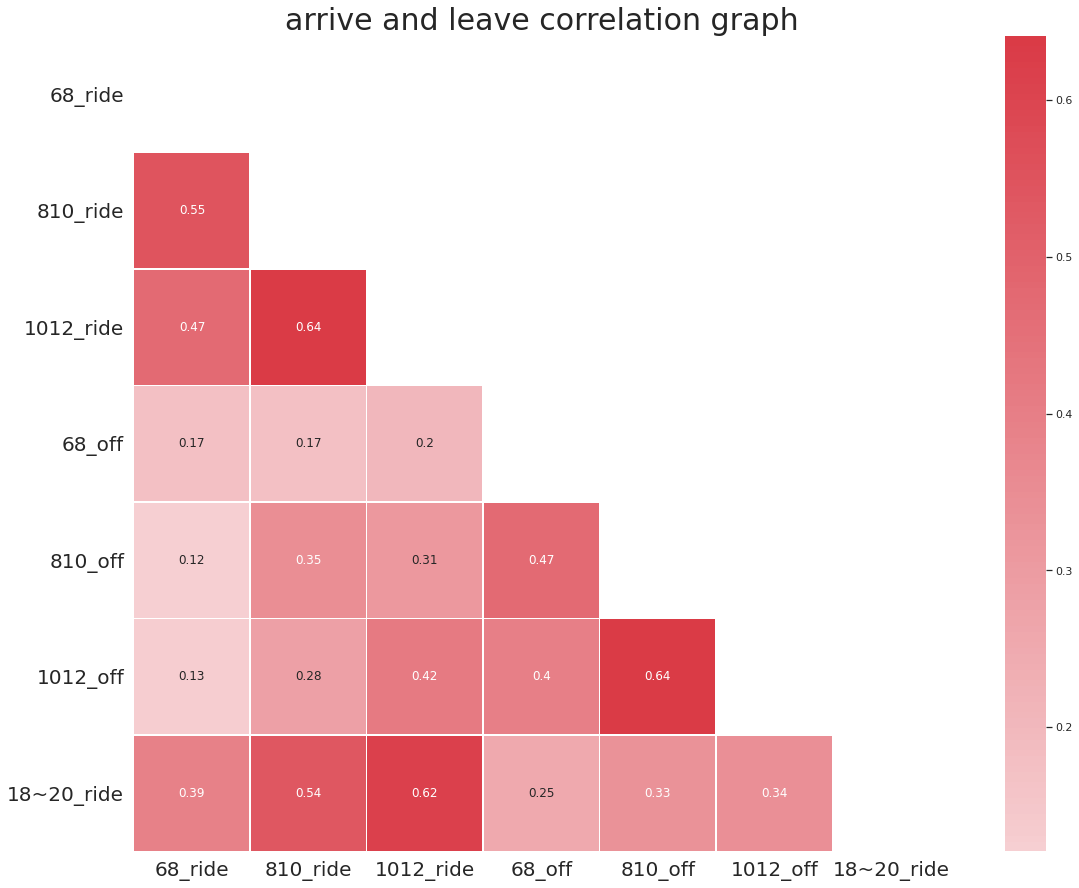

In [181]:
# heatmap 확인
train2 = train[['68_ride', '810_ride', '1012_ride', '68_off', '810_off', '1012_off', '18~20_ride']]
cor = train2.corr()
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

- **오전 10에서 12시 승차량**이 저녁 퇴근시간 6에서 8시 승차량에 가장 영향을 많이 준다!     
그 다음은 오전 8시~10시 승차량이다!  
- 오전 6시에서 8시 승차량은, 8시에서 10시 승차량과 상관계수가 높다.   
- 그리고 8시에서 10시 승차량도, 10시에서 12시 승차량과 상관계수가 높다. 
> **환승**의 영향일까? ㅎㅎ

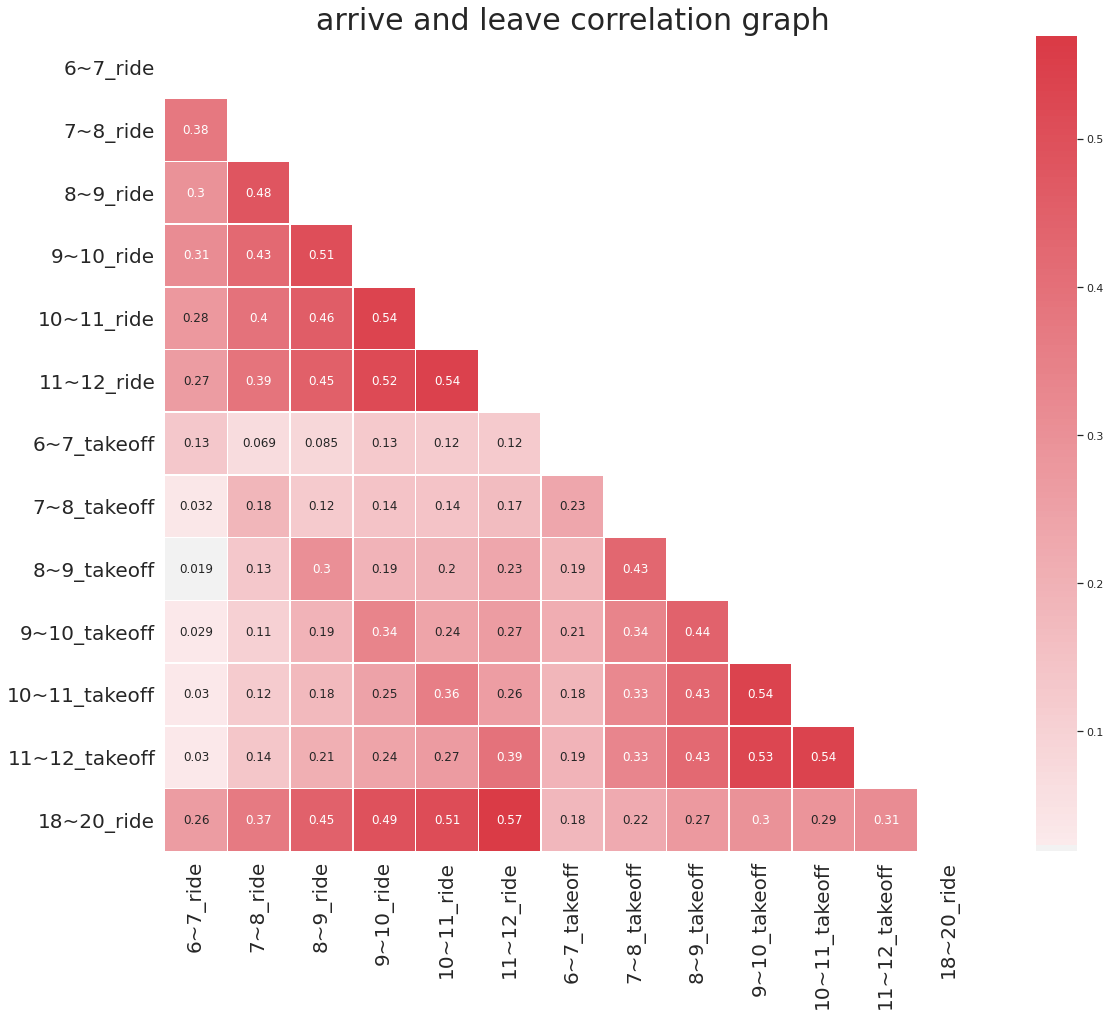

In [182]:
# 비통합 칼럼
train3 = train[['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', 
                '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride']]
cor = train3.corr()
sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,15))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

In [183]:
# 4. 좌표 데이터를 이용한 Feature Engineering
# 제주도의 인구는 서귀포시와 제주시에 몰려있음. 
# 제주, 고산, 성산, 서귀포시의 측정소로 나누어 각각 피쳐로 추가!

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

# 정류소의 위치 확인 가능!

In [184]:
# 정류장의 위치 확인을 위한 groupby
data = train[['latitude', 'longitude', 'station_name']].drop_duplicates(keep='first')
data = data.groupby(['station_name'])['latitude', 'longitude'].mean()
# 정류장 이름이 같은 경우 평균 적용!

# 정류장 목록
data = data.reset_index()
data.head()

,station_name,latitude,longitude
0,(구)구판장,33.329705,126.797965
1,(구)중문동주민센터,33.251085,126.434300
2,(구)중앙파출소,33.247370,126.560713
3,(구)화산초등학교,33.326260,126.797250
4,1100고지휴게소,33.357820,126.463010


In [185]:
# 정류장 지도 표시
for row in data.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc)
map_osm

Output hidden; open in https://colab.research.google.com to view.

In [186]:
# 5. 측정소와 정류장사이 거리 계산(두 좌표간의 거리 계산 : geopy패키지)
# 정류장을 각 측정소와 인접한지 확인!
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( train['latitude'],train['longitude'] )) ]

train['dis_jeju']=t1
train['dis_gosan']=t2
train['dis_seongsan']=t3
train['dis_po']=t4

In [187]:
total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
train['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)

data22=train[['station_name','latitude','longitude','dist_name']].drop_duplicates(keep='first')

Counter(data22['dist_name']) # Counter를 통해 확인
# 0 : 제주/ 1 : 고산/ 2 : 성산/ 3 : 포

Counter({0: 1479, 1: 659, 2: 597, 3: 828})

In [188]:
# dist_name 펼치기
# train = pd.get_dummies(train, columns=['dist_name'])

In [189]:
## 아니 이건 왜 이상하게 나오냐규
# total = pd.DataFrame( list(zip(t1, t2, t3, t3)), columns = ['jeju', 'gosan', 'seongsan', 'po'])
# train['dist_name'] = total.apply(lambda x:x.argmin(), axis=1) # 거리 최소 지점(argmin)을 dist_name으로 지정!
# data2 = train[['station_name', 'latitude', 'longitude', 'dist_name']].drop_duplicates(keep='first')
# data2.head()
# Counter(data2['dist_name'])

In [190]:
# test
t1 = [geopy.distance.vincenty( (i,j), jeju).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t2 = [geopy.distance.vincenty( (i,j), gosan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t3 = [geopy.distance.vincenty( (i,j), seongsan).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]
t4 = [geopy.distance.vincenty( (i,j), po).km for i,j in list( zip( test['latitude'],test['longitude'] )) ]

test['dis_jeju']=t1
test['dis_gosan']=t2
test['dis_seongsan']=t3
test['dis_po']=t4

total=pd.DataFrame( list(zip( t1,t2,t3,t4)),columns=['jeju','gosan','seongsan','po'] )
test['dist_name'] = total.apply(lambda x: x.argmin(), axis=1)
# test = pd.get_dummies(test, columns=['dist_name'])

In [191]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0


In [192]:
# 5. 외부 기상데이터 사용
weather = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/weather.csv', encoding='cp949')

In [193]:
# 결측 개많네 당황스럽다;;
weather.columns

Index(['지점', '지점명', '일시', '기온(°C)', '기온 QC플래그', '강수량(mm)', '강수량 QC플래그',
       '풍속(m/s)', '풍속 QC플래그', '풍향(16방위)', '풍향 QC플래그', '습도(%)', '습도 QC플래그',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)',
       '해면기압 QC플래그', '일조(hr)', '일조 QC플래그', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)', '지면온도 QC플래그', '5cm 지중온도(°C)',
       '10cm 지중온도(°C)', '20cm 지중온도(°C)', '30cm 지중온도(°C)'],
      dtype='object')

In [194]:
weather.isnull().sum() # hmmmm.....

지점                  0
지점명                 0
일시                  0
기온(°C)              0
기온 QC플래그         4371
강수량(mm)          3441
강수량 QC플래그        3560
풍속(m/s)            46
풍속 QC플래그         4344
풍향(16방위)           58
풍향 QC플래그         4332
습도(%)               0
습도 QC플래그         4384
증기압(hPa)            0
이슬점온도(°C)           0
현지기압(hPa)           3
현지기압 QC플래그       4381
해면기압(hPa)           3
해면기압 QC플래그       4381
일조(hr)           2010
일조 QC플래그         2375
일사(MJ/m2)        3206
적설(cm)           4384
3시간신적설(cm)       4384
전운량(10분위)          18
중하층운량(10분위)        10
운형(운형약어)         2903
최저운고(100m )      1354
시정(10m)            15
지면상태(지면상태코드)     4384
현상번호(국내식)        3747
지면온도(°C)            2
지면온도 QC플래그       4382
5cm 지중온도(°C)     3288
10cm 지중온도(°C)    3288
20cm 지중온도(°C)    3288
30cm 지중온도(°C)    3288
dtype: int64

In [195]:
weather.head(2)

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),이슬점온도(°C),현지기압(hPa),현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),운형(운형약어),최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,184,제주,2019-09-01 01:00,23.7,NaN,NaN,NaN,2.1,NaN,180.0,NaN,67,NaN,19.6,17.2,1013.8,NaN,1016.2,NaN,NaN,9.0,NaN,NaN,NaN,10.0,9.0,NaN,73.0,2000.0,NaN,NaN,23.0,NaN,26.0,25.5,25.0,26.9
1,184,제주,2019-09-01 02:00,23.5,NaN,NaN,NaN,1.4,NaN,180.0,NaN,70,NaN,20.2,17.7,1013.7,NaN,1016.1,NaN,NaN,9.0,NaN,NaN,NaN,9.0,9.0,NaN,69.0,2000.0,NaN,NaN,22.9,NaN,25.8,25.3,24.9,26.9


In [196]:
# 지점명 변경.. .이런 정보는 어디서아는거냐.....
weather['지점'] = weather['지점'].map(str)
weather['지점'] = weather['지점'].map({'184':'jeju', '185':'gosan', '188':'seongsan', '189':'po'})

In [197]:
weather.head(2)

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),풍향 QC플래그,습도(%),습도 QC플래그,증기압(hPa),이슬점온도(°C),현지기압(hPa),현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),적설(cm),3시간신적설(cm),전운량(10분위),중하층운량(10분위),운형(운형약어),최저운고(100m ),시정(10m),지면상태(지면상태코드),현상번호(국내식),지면온도(°C),지면온도 QC플래그,5cm 지중온도(°C),10cm 지중온도(°C),20cm 지중온도(°C),30cm 지중온도(°C)
0,jeju,제주,2019-09-01 01:00,23.7,NaN,NaN,NaN,2.1,NaN,180.0,NaN,67,NaN,19.6,17.2,1013.8,NaN,1016.2,NaN,NaN,9.0,NaN,NaN,NaN,10.0,9.0,NaN,73.0,2000.0,NaN,NaN,23.0,NaN,26.0,25.5,25.0,26.9
1,jeju,제주,2019-09-01 02:00,23.5,NaN,NaN,NaN,1.4,NaN,180.0,NaN,70,NaN,20.2,17.7,1013.7,NaN,1016.1,NaN,NaN,9.0,NaN,NaN,NaN,9.0,9.0,NaN,69.0,2000.0,NaN,NaN,22.9,NaN,25.8,25.3,24.9,26.9


In [198]:
# time 분류하기!! 문자열 인덱싱 중요해보임
weather['time'] = [ int(i.split(' ')[1].split(':')[0]) for i in weather['일시']]
weather['일시'] = [i.split(' ')[0] for i in weather['일시']]

In [199]:
# 12시 이전 시간대만 사용(data leakage 방지)
weather = weather.query('time<12')

# 지점, 일시에 따른 기온과 강수량 가져오기
weather2 = weather.groupby(['지점', '일시'])[['기온(°C)', '강수량(mm)']].mean()
weather2 = weather2.reset_index().rename(columns={'일시':'date', '지점':'dist_name', '기온(°C)':'tem', '강수량(mm)':'rain'}).fillna(0.000000)

In [200]:
# to merge
weather2['dist_name'] = weather2['dist_name'].map({'gosan':1, 'seongsan':2, 'jeju':0, 'po':3})
weather2['date'] = pd.to_datetime(weather2['date'])

In [201]:
# 기존 데이터에 merge
train = pd.merge(train, weather2, how='left', on=['dist_name', 'date'])
test = pd.merge(test, weather2, how='left', on=['dist_name', 'date'])

In [202]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,dist_name,tem,rain
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,0,24.109091,0.0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,0,24.109091,0.0


In [203]:
# dist_name 펼치기
train = pd.get_dummies(train, columns=['dist_name'])
test = pd.get_dummies(test, columns=['dist_name'])

In [204]:
train.head(2)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,tem,rain,dist_name_0,dist_name_1,dist_name_2,dist_name_3
0,0,2019-09-01,4270000,1,344,제주썬호텔,33.48990,126.49373,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,1,1.0,7.0,8.0,0.0,0.0,0.0,4.286659,37.692766,37.713630,27.841879,24.109091,0.0,1,0,0,0
1,1,2019-09-01,4270000,1,357,한라병원,33.48944,126.48508,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0,0,0,0,0,0,1,5.0,6.0,11.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,24.109091,0.0,1,0,0,0


# Modeling

In [205]:
train.columns

Index(['id', 'date', 'bus_route_id', 'in_out', 'station_code', 'station_name',
       'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff',
       '18~20_ride', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', '68_ride', '810_ride',
       '1012_ride', '68_off', '810_off', '1012_off', 'dis_jeju', 'dis_gosan',
       'dis_seongsan', 'dis_po', 'tem', 'rain', 'dist_name_0', 'dist_name_1',
       'dist_name_2', 'dist_name_3'],
      dtype='object')

In [211]:
X = train.drop(['id', 'date', 'bus_route_id', 'station_code', 'station_name', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride'], axis=1)
y = train['18~20_ride']
X_test = test.drop(['id', 'date', 'bus_route_id', 'station_code', 'station_name', '6~7_ride', '7~8_ride', '8~9_ride',
       '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff',
       '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff'], axis=1)

In [212]:
X_test.head(2)

,in_out,latitude,longitude,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,68_ride,810_ride,1012_ride,68_off,810_off,1012_off,dis_jeju,dis_gosan,dis_seongsan,dis_po,tem,rain,dist_name_0,dist_name_1,dist_name_2,dist_name_3
0,1,33.48990,126.49373,0,1,0,0,0,0,0,8.0,9.0,10.0,0.0,0.0,1.0,4.286659,37.692766,37.713630,27.841879,23.708333,1.16,1,0,0,0
1,1,33.48944,126.48508,0,1,0,0,0,0,0,7.0,7.0,19.0,0.0,0.0,0.0,4.966848,37.008492,38.465822,27.996179,23.708333,1.16,1,0,0,0


In [215]:
X_test.columns

Index(['in_out', 'latitude', 'longitude', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6',
       '68_ride', '810_ride', '1012_ride', '68_off', '810_off', '1012_off',
       'dis_jeju', 'dis_gosan', 'dis_seongsan', 'dis_po', 'tem', 'rain',
       'dist_name_0', 'dist_name_1', 'dist_name_2', 'dist_name_3'],
      dtype='object')

In [216]:
# valid set 분할(8:2)
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(332338, 26) (83085, 26) (332338,) (83085,)


In [ ]:
### 1. lgbm
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, y_train)
dvalid = lgb.Dataset(X_valid, y_valid, reference=dtrain) # valid를 예측하자

lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.003,
        'num_leaves': 700,
        'max_depth':-1,
        'min_child_weight':5,
        'colsample_bytree': 0.8,
        'subsample':0.7,
        'n_estimators':50000,
        'gamma':0,
#         'reg_lambda':0.05,
#         'reg_alpha':0.05,
        'verbose':-1,
        'seed': 2020,
        'early_stopping_rounds' : 150
    }

model = lgb.train(lgb_params, dtrain, valid_sets=(dtrain, dvalid), valid_names = ('train', 'valid'), 
                   categorical_feature=['weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'dist_name_0', 'dist_name_1', 'dist_name_2', 'dist_name_3'], verbose_eval=100)
val_pred = model.predict(X_valid)
test_pred = model.predict(X_test)

lgb.plot_importance(model, height=0.2, max_num_features = 15, figsize=(10,6))

sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] = test_pred.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/sub1.csv", index=False)


Training until validation scores don't improve for 150 rounds.
[100]	train's rmse: 3.98425	valid's rmse: 4.23979
[200]	train's rmse: 3.49444	valid's rmse: 3.80643
[300]	train's rmse: 3.15516	valid's rmse: 3.51488
[400]	train's rmse: 2.92006	valid's rmse: 3.32445
[500]	train's rmse: 2.7505	valid's rmse: 3.19583
[600]	train's rmse: 2.62231	valid's rmse: 3.10696
[700]	train's rmse: 2.52122	valid's rmse: 3.04569
[800]	train's rmse: 2.4403	valid's rmse: 3.00123


In [219]:
### 2. random forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(max_features=3,
                           min_samples_leaf=2,
                           min_samples_split=2,
                           n_estimators=500,
                           random_state=1217)

rf.fit(X,y) 

rf_pred = rf.predict(X_test) 
test['18~20_ride'] = rf_pred
test[['id','18~20_ride']].to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/sub2.csv",index=False) 

### 3. ensemble
e_pred = (test_pred + rf_pred)/2

sub = pd.read_csv('/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/data/submission_sample.csv')
sub['18~20_ride'] = e_pred.tolist()
sub.to_csv("/content/drive/My Drive/Colab Notebooks/버스 승차인원 예측/sub3.csv", index=False)

KeyboardInterrupt: ignored